## Engineering Rare Labels / Rare Categories

Rare values are labels/ categories within a categorical variable that are only present for a small percentage of the observations.

There is no rule of thumb to determine how small is a small percentage, but typically, any value below 5% may cause over-fitting in trees.

Rare labels may exist in variables that have intrinsically a huge number of labels, or they can be present in variables with few labels (e.g., 2-10). There is no rule of thumb to determine how many different labels is big (and therefore represent high cardinality) and it will depend as well on how many observations there are in the dataset. In a dataset with 1,000 observations, 100 labels may seem a lot, whereas in a dataset with 100,000 observations it may not be so high.

In situations where rare labels are present in variables with only a few categories, the rare label may be adding some information. On the other hand, in variables with a high number of categories, likely there will be very many labels with a low frequency, which will quite likely add noise instead of information. 

Whether rare labels should be processed before training a machine learning algorithm will depend on the dataset and problem at hand. Ideally, if there are not too many variables, you could try and explore the variables and their categories one at a time, and determine whether the rare labels add noise or information.

If, on the other hand, the dataset has very many categorical variables, and exploring one at a time is not an option you may choose to sacrifice the ideal / optimal performance for a higher delivery speed.

### Engineering rare labels

There are multiple ways of accounting for rare labels. Some of them handle rare labels at the same time of converting labels into numbers. I will explain those in the section "Engineer labels of categorical variables".

In this section of the course, I will expand on how to handle rare labels by re-categorising the observation that show rare labels for a certain variable. These observations can be re-categorised by:

- Replacing the rare label by most frequent label
- Grouping the observations that show rare labels into a unique category (with a new label like 'Rare', or 'Other')

In this and the comming lectures I will explain when it is convenient to use one or the other way of replacing rare values, and evaluate the consequences of replacing rare labels in variables with:

- One predominant category
- A small number of different categories
- High cardinality

Specifically, in this lecture I will demonstrate how to work with rare labels in variables with one predominant category using the Mercedes Benz dataset from Kaggle.


===============================================================================

## Real Life example: 

### The Mercedes-Benz Greener Manufacturing challenge in Kaggle

Daimler’s Mercedes-Benz cars are leaders in the premium car industry. With a huge selection of car features and options, customers can choose the customized Mercedes-Benz of their dreams.

To ensure the safety and reliability of each and every unique car configuration before they hit the road, Daimler’s engineers have developed a robust testing system. Testing time varies depending on the different car features and options. The task is to predict the time it takes for a car with certain features to pass the testing. Therefore it is a regression problem: we need to estimate a continuous variable.

The dataset contains a set of car features, the variable names are masked, so it is impossible to find out what each one of them means. The variable to predict is _y_: time to pass the testing.

=============================================================================

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
#from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None) # to display the total number columns present in the dataset

import warnings
warnings.filterwarnings('ignore')

### Functions

Below I will write a few functions to convert categories in categorical variables into numbers so we can use them in sklearn and then to quickly test these variables in a random forest.

In [3]:
def train_rf(X_train, y_train, X_test, y_test, columns):
    # function to train the random forest
    # and test it on train and test sets
    
    rf = RandomForestRegressor(n_estimators=800, random_state=39)
    
    if type(columns)==str: # if we train using only 1 variable (pass a string instead of list in the "columns" argument of the function)
        rf.fit(X_train[columns].to_frame(), y_train.values)
        pred_train = rf.predict(X_train[columns].to_frame())
        pred_test = rf.predict(X_test[columns].to_frame())
        
    else: # if we train using multiple variables (pass a list in the argument "columns")
        rf.fit(X_train[columns], y_train.values)
        pred_train = rf.predict(X_train[columns])
        pred_test = rf.predict(X_test[columns])
        
    print('Train set')
    print('Random Forests mse: {}'.format(mean_squared_error(y_train, pred_train)))
    print('Test set')
    print('Random Forests mse: {}'.format(mean_squared_error(y_test, pred_test)))

In [4]:
def labels_to_numbers(X_train, X_test, columns):
    # function to encode labels into numbers
    # each label will be assigned an ordinal number from 0 onwards
    
    for col in columns:
        labels_dict = {k:i for i, k in enumerate(X_train[col].unique(), 0)}
        X_train.loc[:, col] = X_train.loc[:, col].map(labels_dict )
        X_test.loc[:, col] = X_test.loc[:, col].map(labels_dict)

## Mercedes Benz dataset

In [5]:
# let's load the dataset with just the columns that we need for this exercise

cols_to_use = ['y', 'X1', 'X2', 'X3', 'X6']
data = pd.read_csv('mercedesbenz.csv', usecols=cols_to_use)
data.head()

,y,X1,X2,X3,X6
0,130.81,v,at,a,j
1,88.53,t,av,e,l
2,76.26,w,n,c,j
3,80.62,t,n,f,l
4,78.02,v,n,f,d


In [6]:
# let's check at the different number of labels within each variable

cols_to_use = ['X1', 'X2', 'X3', 'X6']

for col in cols_to_use:
    print('variable: ', col, ' number of labels: ', len(data[col].unique()) )
print('total cars: ', len(data))

variable:  X1  number of labels:  27
variable:  X2  number of labels:  44
variable:  X3  number of labels:  7
variable:  X6  number of labels:  12
total cars:  4209


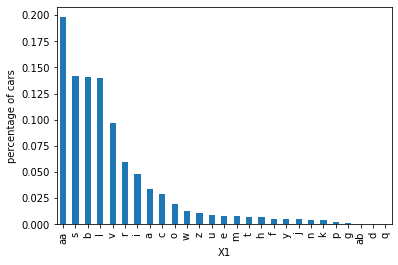

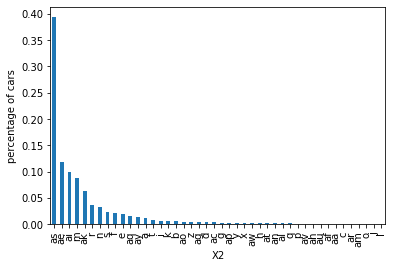

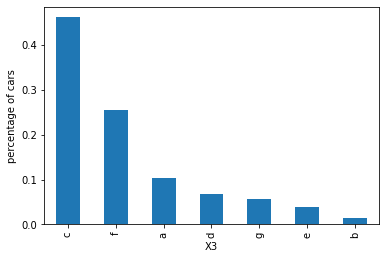

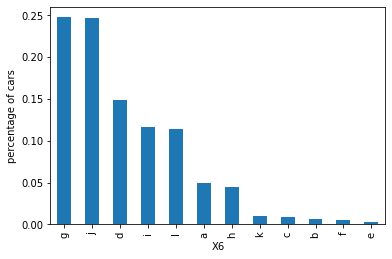

In [7]:
# let's plot how frequently each label appear in the dataset, for each of the categorical variables

total_cars = len(data)
for col in cols_to_use:
    temp_df = pd.Series(data[col].value_counts() / total_cars)
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)
    fig.set_ylabel('percentage of cars')
    plt.show()

We can see that for each of the above variables, some labels appear for more than 10% of the observations in the dataset, but very many appear in less than 10% or even 5% of the observations. These are infrequent labels (Rare Values), and could cause over-fitting.


In [8]:
# let's separate into training and testing set
X_train, X_test, y_train, y_test = train_test_split(data[cols_to_use].fillna(0), data.y,
                                                    test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((2946, 4), (1263, 4))

In [9]:
# let's automate the replacement of infrequent categories for the label 'rare' in all
# categorical variables as we have been doing so far (i.e., by rare or frequent label imputation)

for col in cols_to_use:
    # find non-rare categories:those are the ones we will keep 
    total_cars = len(X_train)
    temp_df = pd.Series(X_train[col].value_counts() / total_cars)
    categories_to_keep = temp_df[temp_df>=0.1].index # non-rare labels
    
    # group observations with infrequent labels under the most frequent label 
    # find frequent label
    frequent_cat = X_train.groupby(col)[col].count().sort_values().tail(1).index.values[0]
       
    # group observations with infrequent labels under new label "Rare"
    # train set
    X_train[col+'_rare_imp'] = np.where(X_train[col].isin(categories_to_keep), X_train[col], 'rare')
    X_test[col+'_rare_imp'] = np.where(X_test[col].isin(categories_to_keep), X_test[col], 'rare')
       
    # replace in train set
    X_train[col+'_freq_imp'] = np.where(X_train[col].isin(categories_to_keep), X_train[col], frequent_cat)
    X_test[col+'_freq_imp'] = np.where(X_test[col].isin(categories_to_keep), X_test[col], frequent_cat)

    
X_train.head()

,X1,X2,X3,X6,X1_rare_imp,X1_freq_imp,X2_rare_imp,X2_freq_imp,X3_rare_imp,X3_freq_imp,X6_rare_imp,X6_freq_imp
3059,aa,ai,c,g,aa,aa,rare,as,c,c,g,g
3014,b,m,c,i,b,b,rare,as,c,c,i,i
3368,o,f,f,l,rare,aa,rare,as,f,f,l,l
2772,aa,as,d,j,aa,aa,as,as,rare,c,j,j
3383,v,e,c,g,rare,aa,rare,as,c,c,g,g


In [10]:
# let's make lists with the variables after the different imputed methods
# or comparatively the original variable
# so we can train random forests using these lists

cols_to_use = ['X1', 'X2','X3', 'X6']
cols_freq = [x+'_freq_imp' for x in cols_to_use]
cols_rare = [x+'_rare_imp' for x in cols_to_use]

In [11]:
[x for x in X_test.X2.unique() if x not in X_train.X2.unique()]

['ar', 'j']

There are 2 categories in the test set not present in the training set, so this will not allow us to build a random forest, somehow, we need to replace this by something else. Therefore, we see quite clearly, that even if rare label does not boost the performance of the algorithm, it is acually required to account for labels present in the test set that are not present in the training set.

In [12]:
frequent_cat = X_train.groupby('X2')['X2'].count().sort_values().tail(1).index.values[0]
frequent_cat

'as'

In [13]:
# here I will replace those 2 by the most frequent category
#so I can build the trees and be able to compare them with the other
# engineered variables

X_test['X2'] = np.where(X_test['X2'].isin(['ar', 'j']), frequent_cat, X_test['X2'])
[x for x in X_test.X2.unique() if x not in X_train.X2.unique()]

[]

Perfect, it worked, now I can continue with the random forest comparison

In [14]:
# I will build RF using the (almost) original variables
labels_to_numbers(X_train, X_test, cols_to_use)
train_rf(X_train, y_train, X_test, y_test, cols_to_use)

Train set
Random Forests mse: 73.52558287154191
Test set
Random Forests mse: 147.7965152383124


In [15]:
# or those in which the infrequent labels were grouped under the 'rare' label
labels_to_numbers(X_train, X_test, cols_rare)
train_rf(X_train, y_train, X_test, y_test, cols_rare)

Train set
Random Forests mse: 120.70163006877415
Test set
Random Forests mse: 156.60887148893417


In [16]:
# or those in which the infrequent labels were grouped under the most frequent label
labels_to_numbers(X_train, X_test, cols_freq)
train_rf(X_train, y_train, X_test, y_test, cols_freq)

Train set
Random Forests mse: 136.65168543109723
Test set
Random Forests mse: 165.94902177678532


Re-grouping the infrequent categories under the new category 'Rare' outperforms replacing the rare labels by the most frequent one (mse test 156 vs 165)  or using the original variables.

### Conclusion

Engineering of rare labels causes in many cases an increased performance of tree based machine learning methods. In addition, to get the most value from the data science / data analysis /  machine learning project, it is a good idea, whenever possible, to understand the distribution of observations among the different labels, the cardinality of the variables, and their relationship to the target.

**That is all for this demonstration. I hope you enjoyed the notebook, and see you in the next one.**